In [1]:
# [CLS]トークンを利用
# 相関係数を損失関数とする

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='013'
    debug=False  # False
    wandb=True
    resume=None  # [None, 'auto', 'allow', 'must']
    save_checkpoint=True
    competition='PPPM'
    seed=42

    # Dataset & DataLoader
    tokenizer_kwargs={
        'do_lower_case': True,
    }
    num_workers=4
    batch_size=16
    max_len=512

    # Model
    model="microsoft/deberta-v3-large"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    epochs=4
    gradient_accumulation_steps=1
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [3]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Tue Jun  7 07:58:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    43W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [4]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
CPU times: user 29.1 ms, sys: 32.6 ms, total: 61.7 ms
Wall time: 1.55 s


In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [6]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    !pip install -q wandb
    import wandb

    if CFG.debug:
        anony = "must"
        print('It is debugging.')
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    else:
        try:
            # from kaggle_secrets import UserSecretsClient
            # user_secrets = UserSecretsClient()
            # secret_value_0 = user_secrets.get_secret("wandb_api")
            with open('/content/drive/MyDrive/kaggle/wandb') as f:
                wandb_api_key = f.readline().rstrip('\n')
            wandb.login(key=wandb_api_key)
            anony = None
        except:
            anony = "must"
            print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                        name=CFG.exp,
                        config=class2dict(CFG),
                    #  group=CFG.exp,
                        job_type="train",
                        resume=CFG.resume,  # 'auto'
                        anonymous=anony)

wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Library

In [7]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [9]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [10]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [11]:
# ';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text

train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)

In [12]:
# anchor, target, context_text をそれぞれ一文ずつとみなす
# anchorとtarget逆順にも並べる
train['text'] = train['anchor'] + '.' + ' [SEP] ' + train['target'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text'] = test['anchor'] + '.' + ' [SEP] ' + test['target'] + '.' + ' [SEP] '  + test['context_text'] + '.'
train['text_rev'] = train['target'] + '.' + ' [SEP] ' + train['anchor'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text_rev'] = test['target'] + '.' + ' [SEP] ' + test['anchor'] + '.' + ' [SEP] '  + test['context_text'] + '.'
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text,text_rev
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] abatement of pollution. [SEP]...,abatement of pollution. [SEP] abatement. [SEP]...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] act of abating. [SEP] HUMAN N...,act of abating. [SEP] abatement. [SEP] HUMAN N...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] active catalyst. [SEP] HUMAN ...,active catalyst. [SEP] abatement. [SEP] HUMAN ...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] eliminating process. [SEP] HU...,eliminating process. [SEP] abatement. [SEP] HU...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] forest region. [SEP] HUMAN NE...,forest region. [SEP] abatement. [SEP] HUMAN NE...


,id,anchor,target,context,context_text,text,text_rev
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum. [SEP] inorganic photoconductor drum....,inorganic photoconductor drum. [SEP] opc drum....
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,adjust gas flow. [SEP] altering gas flow. [SEP...,altering gas flow. [SEP] adjust gas flow. [SEP...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS. TRANSPORTING. VEHICLES ...,lower trunnion. [SEP] lower locating. [SEP] PE...,lower locating. [SEP] lower trunnion. [SEP] PE...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...,cap component. [SEP] upper portion. [SEP] TEXT...,upper portion. [SEP] cap component. [SEP] TEXT...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation. [SEP] artificial neural ne...,artificial neural network. [SEP] neural stimul...


# EDA

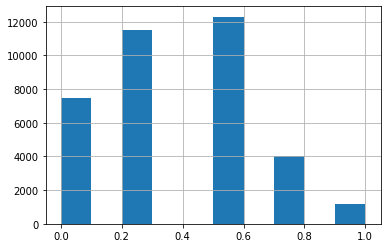

In [13]:
train['score'].hist()

In [14]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [15]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [16]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [17]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, **CFG.tokenizer_kwargs)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [18]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 106


In [19]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, phase: str ='train'):
        self.cfg = cfg
        self.texts = df['text'].values
        self.texts_rev = df['text_rev'].values
        self.labels = df['score'].values

        # # 学習はオーギュメンテーション
        # rev_mask = (np.random.rand(len(df))) > 0.5  # 0~1の一様分布が閾値より大きいならmask
        # texts_aug = np.where(rev_mask, self.texts_rev, self.texts)
        # if phase=='train':
        #     self.texts = texts_aug

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [20]:
# train_dataset = TrainDataset(CFG, train, 'train')
# inputs, label = train_dataset[0]
# print(inputs)
# print(label)

# Model

In [21]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]  # (bs, max_len, hidden_size)
        feature = last_hidden_states[:, 0, :]  # [CLS]トークンを利用
        # feature = torch.mean(last_hidden_states, dim=1)  # 全トークンを平均
        # weights = self.attention(last_hidden_states)
        # feature = torch.sum(weights * last_hidden_states, dim=1)  # 全トークンを全トークンをattentionレイヤで加重平均
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Loss

In [22]:
class CorrLoss(nn.Module):
    """
    use 1 - correlational coefficience between the output of the network and the target as the loss
    input (o, t):
        o: Variable of size (batch_size, 1) output of the network
        t: Variable of size (batch_size, 1) target value
    output (corr):
        corr: Variable of size (1)
    """
    def __init__(self):
        super(CorrLoss, self).__init__()

    def forward(self, o, t):
        assert(o.size() == t.size())
        # calcu z-score for o and t
        o_m = o.mean(dim = 0)
        o_s = o.std(dim = 0)
        o_z = (o - o_m)/o_s

        t_m = t.mean(dim =0)
        t_s = t.std(dim = 0)
        t_z = (t - t_m)/t_s

        # calcu corr between o and t
        tmp = o_z * t_z
        corr = tmp.mean(dim = 0)
        return  1 - corr

# Helpler functions

In [23]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [24]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds, phase='train')
    valid_dataset = TrainDataset(CFG, valid_folds, phase='val')

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = CorrLoss()
    
    best_score = 0.
    epoch = 0

    if wandb.run.resumed:
        checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['model'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        # amp.load_state_dict(checkpoint['amp'])
        epoch = checkpoint['epoeh'] + 1  # 保存時のエポックが読み出されるので+1
        best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 0 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

Epoch: [1][0/1693] Elapsed 0m 1s (remain 31m 3s) Loss: 0.8127(0.8127) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1693] Elapsed 1m 20s (remain 21m 4s) Loss: 0.3902(0.5635) Grad: 43409.8945  LR: 0.00001999  
Epoch: [1][200/1693] Elapsed 2m 38s (remain 19m 39s) Loss: 0.3930(0.4789) Grad: 21109.0957  LR: 0.00001996  
Epoch: [1][300/1693] Elapsed 3m 57s (remain 18m 17s) Loss: 0.2143(0.4277) Grad: 14068.6777  LR: 0.00001990  
Epoch: [1][400/1693] Elapsed 5m 16s (remain 16m 58s) Loss: 0.1644(0.3989) Grad: 13639.8418  LR: 0.00001983  
Epoch: [1][500/1693] Elapsed 6m 34s (remain 15m 39s) Loss: 0.1952(0.3755) Grad: 14190.4775  LR: 0.00001973  
Epoch: [1][600/1693] Elapsed 7m 53s (remain 14m 20s) Loss: 0.2315(0.3542) Grad: 16383.9092  LR: 0.00001961  
Epoch: [1][700/1693] Elapsed 9m 12s (remain 13m 2s) Loss: 0.3290(0.3417) Grad: 16128.4756  LR: 0.00001948  
Epoch: [1][800/1693] Elapsed 10m 31s (remain 11m 43s) Loss: 0.3775(0.3328) Grad: 22407.9414  LR: 0.00001932  
Epoch: [1][900/1693] Elapsed 11

Epoch 1 - avg_train_loss: 0.2858  avg_val_loss: nan  time: 1454s
Epoch 1 - Score: 0.7337


EVAL: [586/587] Elapsed 2m 0s (remain 0m 0s) Loss: 0.5785(nan) 


Epoch 1 - Save Best Score: 0.7337 Model


Epoch: [2][0/1693] Elapsed 0m 1s (remain 39m 24s) Loss: 0.2815(0.2815) Grad: 241268.6719  LR: 0.00001707  
Epoch: [2][100/1693] Elapsed 1m 25s (remain 22m 24s) Loss: 0.1596(0.1736) Grad: 210608.0469  LR: 0.00001673  
Epoch: [2][200/1693] Elapsed 2m 45s (remain 20m 25s) Loss: 0.1168(0.1762) Grad: 113395.2266  LR: 0.00001638  
Epoch: [2][300/1693] Elapsed 4m 3s (remain 18m 46s) Loss: 0.1440(0.1720) Grad: 202594.2656  LR: 0.00001602  
Epoch: [2][400/1693] Elapsed 5m 22s (remain 17m 18s) Loss: 0.1286(0.1705) Grad: 127564.5938  LR: 0.00001564  
Epoch: [2][500/1693] Elapsed 6m 40s (remain 15m 54s) Loss: 0.2783(0.1700) Grad: 262355.5000  LR: 0.00001525  
Epoch: [2][600/1693] Elapsed 7m 59s (remain 14m 31s) Loss: 0.1083(0.1693) Grad: 102541.5156  LR: 0.00001485  
Epoch: [2][700/1693] Elapsed 9m 18s (remain 13m 10s) Loss: 0.2952(0.1704) Grad: 182188.5938  LR: 0.00001444  
Epoch: [2][800/1693] Elapsed 10m 37s (remain 11m 49s) Loss: 0.2649(0.1697) Grad: 241857.2031  LR: 0.00001402  
Epoch: [2][90

Epoch 2 - avg_train_loss: 0.1669  avg_val_loss: nan  time: 1460s
Epoch 2 - Score: 0.7357


EVAL: [586/587] Elapsed 2m 0s (remain 0m 0s) Loss: 0.3335(nan) 


Epoch 2 - Save Best Score: 0.7357 Model


Epoch: [3][0/1693] Elapsed 0m 1s (remain 42m 57s) Loss: 0.1107(0.1107) Grad: 91720.8359  LR: 0.00001000  
Epoch: [3][100/1693] Elapsed 1m 24s (remain 22m 7s) Loss: 0.0782(0.1401) Grad: 48698.6680  LR: 0.00000953  
Epoch: [3][200/1693] Elapsed 2m 43s (remain 20m 15s) Loss: 0.1846(0.1415) Grad: 282708.5938  LR: 0.00000907  
Epoch: [3][300/1693] Elapsed 4m 2s (remain 18m 41s) Loss: 0.1346(0.1412) Grad: 93548.1797  LR: 0.00000861  
Epoch: [3][400/1693] Elapsed 5m 21s (remain 17m 15s) Loss: 0.1505(0.1425) Grad: 95966.7734  LR: 0.00000815  
Epoch: [3][500/1693] Elapsed 6m 40s (remain 15m 52s) Loss: 0.1793(0.1418) Grad: 223547.6094  LR: 0.00000770  
Epoch: [3][600/1693] Elapsed 7m 58s (remain 14m 30s) Loss: 0.1793(0.1447) Grad: 110885.7266  LR: 0.00000725  
Epoch: [3][700/1693] Elapsed 9m 17s (remain 13m 8s) Loss: 0.2318(0.1467) Grad: 201817.8750  LR: 0.00000681  
Epoch: [3][800/1693] Elapsed 10m 36s (remain 11m 48s) Loss: 0.1089(0.1484) Grad: 139932.6562  LR: 0.00000637  
Epoch: [3][900/1693

Epoch 3 - avg_train_loss: 0.1487  avg_val_loss: nan  time: 1460s
Epoch 3 - Score: 0.7326


EVAL: [586/587] Elapsed 2m 0s (remain 0m 0s) Loss: 0.3333(nan) 
Epoch: [4][0/1693] Elapsed 0m 1s (remain 31m 41s) Loss: 0.0823(0.0823) Grad: 56531.3203  LR: 0.00000293  
Epoch: [4][100/1693] Elapsed 1m 23s (remain 22m 3s) Loss: 0.1097(0.1477) Grad: 70464.8047  LR: 0.00000261  
Epoch: [4][200/1693] Elapsed 2m 43s (remain 20m 12s) Loss: 0.2023(0.1455) Grad: 246295.5781  LR: 0.00000230  
Epoch: [4][300/1693] Elapsed 4m 2s (remain 18m 39s) Loss: 0.1160(0.1430) Grad: 107544.9375  LR: 0.00000202  
Epoch: [4][400/1693] Elapsed 5m 20s (remain 17m 14s) Loss: 0.1256(0.1416) Grad: 132522.4844  LR: 0.00000175  
Epoch: [4][500/1693] Elapsed 6m 39s (remain 15m 50s) Loss: 0.2666(0.1439) Grad: 236300.0625  LR: 0.00000149  
Epoch: [4][600/1693] Elapsed 7m 58s (remain 14m 29s) Loss: 0.2132(0.1442) Grad: 279868.2188  LR: 0.00000126  
Epoch: [4][700/1693] Elapsed 9m 17s (remain 13m 8s) Loss: 0.1005(0.1421) Grad: 73128.3359  LR: 0.00000104  
Epoch: [4][800/1693] Elapsed 10m 36s (remain 11m 48s) Loss: 0.085

Epoch 4 - avg_train_loss: 0.1391  avg_val_loss: nan  time: 1460s
Epoch 4 - Score: 0.7313


EVAL: [586/587] Elapsed 2m 0s (remain 0m 0s) Loss: 0.3427(nan) 


========== fold: 0 result ==========
Score: 0.7357
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1725] Elapsed 0m 1s (remain 35m 7s) Loss: 0.7009(0.7009) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1725] Elapsed 1m 22s (remain 22m 11s) Loss: 0.5196(0.5470) Grad: 40183.6953  LR: 0.00001999  
Epoch: [1][200/1725] Elapsed 2m 41s (remain 20m 24s) Loss: 0.2862(0.4373) Grad: 22355.1016  LR: 0.00001996  
Epoch: [1][300/1725] Elapsed 4m 0s (remain 18m 57s) Loss: 0.3943(0.3921) Grad: 29245.8047  LR: 0.00001991  
Epoch: [1][400/1725] Elapsed 5m 19s (remain 17m 33s) Loss: 0.3111(0.3702) Grad: 23519.5391  LR: 0.00001983  
Epoch: [1][500/1725] Elapsed 6m 37s (remain 16m 12s) Loss: 0.2275(0.3486) Grad: 18461.9922  LR: 0.00001974  
Epoch: [1][600/1725] Elapsed 7m 56s (remain 14m 51s) Loss: 0.3057(0.3359) Grad: 22935.9160  LR: 0.00001963  
Epoch: [1][700/1725] Elapsed 9m 15s (remain 13m 31s) Loss: 0.2894(0.3254) Grad: 27158.9766  LR: 0.00001950  
Epoch: [1][800/1725] Elapsed 10m 34s (remain 12m 11s) Loss: 0.5877(0.3151) Grad: 27773.3887  LR: 0.00001934  
Epoch: [1][900/1725] Elapsed 1

Epoch 1 - avg_train_loss: 0.2730  avg_val_loss: nan  time: 1476s
Epoch 1 - Score: 0.7096


EVAL: [553/554] Elapsed 1m 53s (remain 0m 0s) Loss: 0.1030(nan) 


Epoch 1 - Save Best Score: 0.7096 Model


Epoch: [2][0/1725] Elapsed 0m 1s (remain 37m 8s) Loss: 0.1547(0.1547) Grad: 162222.6406  LR: 0.00001707  
Epoch: [2][100/1725] Elapsed 1m 24s (remain 22m 33s) Loss: 0.1030(0.1894) Grad: 124292.0469  LR: 0.00001674  
Epoch: [2][200/1725] Elapsed 2m 43s (remain 20m 36s) Loss: 0.2506(0.1803) Grad: 123368.7422  LR: 0.00001640  
Epoch: [2][300/1725] Elapsed 4m 1s (remain 19m 4s) Loss: 0.1848(0.1813) Grad: 183802.2188  LR: 0.00001604  
Epoch: [2][400/1725] Elapsed 5m 20s (remain 17m 38s) Loss: 0.2651(0.1763) Grad: 153756.3438  LR: 0.00001567  
Epoch: [2][500/1725] Elapsed 6m 39s (remain 16m 15s) Loss: 0.3864(0.1738) Grad: 395944.5000  LR: 0.00001529  
Epoch: [2][600/1725] Elapsed 7m 58s (remain 14m 54s) Loss: 0.0886(0.1726) Grad: 101264.0469  LR: 0.00001490  
Epoch: [2][700/1725] Elapsed 9m 17s (remain 13m 33s) Loss: 0.1699(0.1711) Grad: 196855.5312  LR: 0.00001450  
Epoch: [2][800/1725] Elapsed 10m 35s (remain 12m 13s) Loss: 0.3047(0.1705) Grad: 295073.8750  LR: 0.00001409  
Epoch: [2][900/

Epoch 2 - avg_train_loss: 0.1645  avg_val_loss: nan  time: 1479s
Epoch 2 - Score: 0.7244


EVAL: [553/554] Elapsed 1m 53s (remain 0m 0s) Loss: 0.1160(nan) 


Epoch 2 - Save Best Score: 0.7244 Model


Epoch: [3][0/1725] Elapsed 0m 1s (remain 44m 7s) Loss: 0.2149(0.2149) Grad: 102127.5000  LR: 0.00001000  
Epoch: [3][100/1725] Elapsed 1m 25s (remain 22m 52s) Loss: 0.1504(0.1516) Grad: 130510.3047  LR: 0.00000955  
Epoch: [3][200/1725] Elapsed 2m 44s (remain 20m 50s) Loss: 0.1434(0.1509) Grad: 119453.7578  LR: 0.00000909  
Epoch: [3][300/1725] Elapsed 4m 3s (remain 19m 13s) Loss: 0.1334(0.1498) Grad: 67398.5859  LR: 0.00000864  
Epoch: [3][400/1725] Elapsed 5m 22s (remain 17m 44s) Loss: 0.1136(0.1511) Grad: 141740.1250  LR: 0.00000819  
Epoch: [3][500/1725] Elapsed 6m 41s (remain 16m 20s) Loss: 0.1312(0.1517) Grad: 134187.1406  LR: 0.00000775  
Epoch: [3][600/1725] Elapsed 7m 59s (remain 14m 57s) Loss: 0.1465(0.1507) Grad: 115671.2422  LR: 0.00000731  
Epoch: [3][700/1725] Elapsed 9m 18s (remain 13m 35s) Loss: 0.1536(0.1498) Grad: 131062.5000  LR: 0.00000687  
Epoch: [3][800/1725] Elapsed 10m 37s (remain 12m 15s) Loss: 0.0958(0.1485) Grad: 81804.9141  LR: 0.00000644  
Epoch: [3][900/1

Epoch 3 - avg_train_loss: 0.1461  avg_val_loss: nan  time: 1479s
Epoch 3 - Score: 0.7288


EVAL: [553/554] Elapsed 1m 53s (remain 0m 0s) Loss: 0.1119(nan) 


Epoch 3 - Save Best Score: 0.7288 Model


Epoch: [4][0/1725] Elapsed 0m 1s (remain 45m 35s) Loss: 0.1337(0.1337) Grad: 178704.8750  LR: 0.00000293  
Epoch: [4][100/1725] Elapsed 1m 24s (remain 22m 38s) Loss: 0.1513(0.1446) Grad: 90341.9062  LR: 0.00000262  
Epoch: [4][200/1725] Elapsed 2m 44s (remain 20m 50s) Loss: 0.0874(0.1416) Grad: 22828.6172  LR: 0.00000232  
Epoch: [4][300/1725] Elapsed 4m 3s (remain 19m 12s) Loss: 0.1546(0.1398) Grad: 89075.8984  LR: 0.00000204  
Epoch: [4][400/1725] Elapsed 5m 22s (remain 17m 44s) Loss: 0.1012(0.1398) Grad: 90183.9062  LR: 0.00000177  
Epoch: [4][500/1725] Elapsed 6m 41s (remain 16m 20s) Loss: 0.1038(0.1389) Grad: 44271.0430  LR: 0.00000152  
Epoch: [4][600/1725] Elapsed 7m 59s (remain 14m 57s) Loss: 0.1698(0.1377) Grad: 70680.6406  LR: 0.00000129  
Epoch: [4][700/1725] Elapsed 9m 18s (remain 13m 35s) Loss: 0.1201(0.1373) Grad: 48299.5820  LR: 0.00000107  
Epoch: [4][800/1725] Elapsed 10m 37s (remain 12m 15s) Loss: 0.0984(0.1374) Grad: 47998.6484  LR: 0.00000088  
Epoch: [4][900/1725] 

Epoch 4 - avg_train_loss: 0.1357  avg_val_loss: nan  time: 1479s
Epoch 4 - Score: 0.7285


EVAL: [553/554] Elapsed 1m 53s (remain 0m 0s) Loss: 0.1070(nan) 


========== fold: 1 result ==========
Score: 0.7288
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1741] Elapsed 0m 1s (remain 43m 37s) Loss: 0.7080(0.7080) Grad: nan  LR: 0.00002000  
Epoch: [1][100/1741] Elapsed 1m 23s (remain 22m 32s) Loss: 0.7362(0.5935) Grad: 26910.5723  LR: 0.00001999  
Epoch: [1][200/1741] Elapsed 2m 42s (remain 20m 41s) Loss: 0.2049(0.4535) Grad: 13329.2881  LR: 0.00001996  


In [ ]:
oof_df.iloc[np.random.default_rng().permutation(np.arange(len(oof_df)))[:10]]

In [ ]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()